# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate synthetic data

In [148]:
# external_input_params = {
#     "external_input_type": "two_peaks_with_varying_timing",
#     "std1": 10,
#     "corr1": 0.5,
#     "std2": 25,
#     "corr2": 0.9,
#     "use_two_modes": False,
# }

# external_input_params = {
#     "external_input_type": "two_peaks_with_varying_slope",
#     "max_slope": 0.01,
#     "min_slope": -0.01,
#     # "max_slope": 0.0,
#     # "min_slope": -0.0,
# }

# external_input_params = {
#     "external_input_type": "two_peaks_with_varying_gain",
#     "max_gain": 0.03,
#     "min_gain": -0.03,
# }

external_input_params = {
    "external_input_type": "two_peaks_with_varying_timing_baseline_slope",
    "std1": 10,
    "corr1": 0.0,
    "std2": 25,
    "corr2": 0.0,
    "use_two_modes": True,
    "max_slope": 0.01,
    "min_slope": -0.01,
    "max_gain": 0.03,
    "min_gain": -0.03,
}

# external_input_params = {
#     "external_input_type": "two_peaks_with_all_varying",
#     "std1": 10,
#     "corr1": 0.5,
#     "std2": 25,
#     "corr2": 0.5,
#     "use_two_modes": False,
#     "gp_time_constant": 100,
#     "gp_amplitude": 0.02,
# }

spikes, trial_info, current = GLM.EIF_simulator(
    ntrial=2000,
    nneuron=50,
    conn=0.0,
    # conn=0.005,
    params=external_input_params, 
    return_trial_info=True,
    return_current=True,
)

print(f"Size of spikes array in MB: {spikes.nbytes / (1024 * 1024):.2f} MB")


100%|██████████| 2000/2000 [03:19<00:00, 10.05it/s]

Size of spikes array in MB: 228.88 MB


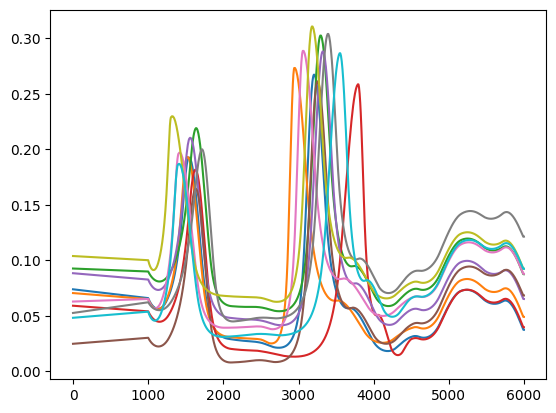

In [149]:
plt.plot(current[:,0,0:10])

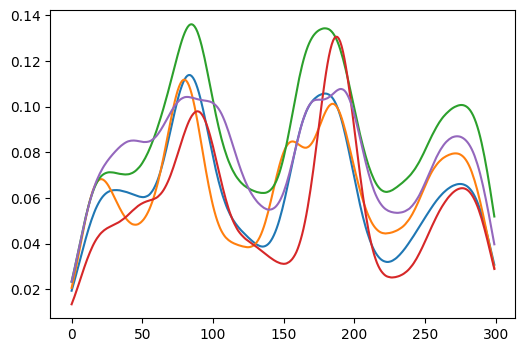

In [150]:
plt.figure(figsize=(6,4))
# Define Gaussian kernel for smoothing
kernel_width = 10
kernel = np.exp(-np.arange(-3*kernel_width, 3*kernel_width+1)**2 / (2*kernel_width**2))
kernel = kernel / kernel.sum()  # Normalize

for trial in range(5):  # Plot first 20 trials
    # Get mean across neurons for this trial
    trial_mean = spikes[:,:,trial].mean(axis=1)
    # Apply kernel smoothing via convolution
    smoothed = np.convolve(trial_mean, kernel, mode='same')
    plt.plot(smoothed)


Text(0.5, 1.0, 'Spike raster for neuron 0')

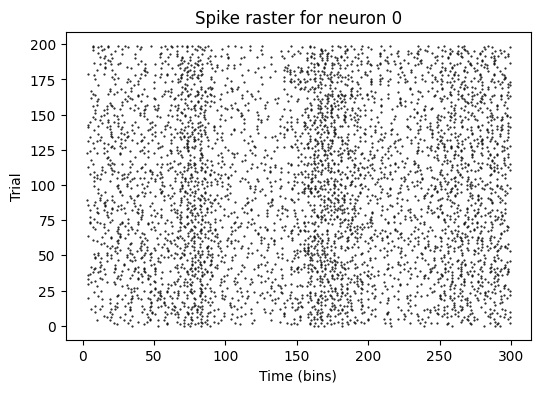

In [151]:
# Plot raster for one example neuron
neuron_idx = 0  # Choose first neuron
plt.figure(figsize=(6,4))
for trial in range(200):  # Plot first 20 trials
    spike_times = np.where(spikes[:,neuron_idx,trial])[0]
    plt.plot(spike_times, trial*np.ones_like(spike_times), '.', markersize=1, color='black')
plt.xlabel('Time (bins)')
plt.ylabel('Trial')
plt.title(f'Spike raster for neuron {neuron_idx}')


In [152]:
nneuron = spikes.shape[1]//2

synthetic_dataloader = Simple_dataloader_from_spikes(
    [spikes[:,:nneuron,:], spikes[:,nneuron:,:]],
    npadding=50,
    train_ratio=0.7,
    val_ratio=0.1,
    batch_size=64,
    verbose=True
)

# Train a model

Current problems:
- Not stable! Run the code multiple times, the results are different. **Solved by temporal correlation penalty**
- The coupling effect is not capturing what it should capture. ** **

Things I want to try:
- see if the baseline looks good. **YES**
- I want to get a clear two modes in t-sne plot, since the ground truth is two modes. **YES**
- Play with hyperparameters, see what appect the results. **lr is still very important. Epoch is also important.**
- Try make coupling effect weaker by setting initial value to be around zero. I don't want to see the coupling effect being too strong. **can be done by frozing Transformer encoder**
- See how would overlapping penalty affect the results. overlapping_penalty=None: 0.2283
overlapping_penalty=1e0: 0.2289. **but overlapping penalty makes coupling very small**
- Try penalty temporal correlation. **Works great!**
- Try not frozing Transformer encoder. **(a different dataset than the previous one) 0.2300 vs 0.2308. So Yes, frozing encoder**
- Try cls token. **No, will lead to mode collapse**
- Get a set of hyperparameters that works in both conn=0.0 and conn=0.01. ** **
- compare with no f(z,t) but just f(t). The coupling effect should be much stronger. 


- I don't know why the first element in both sending and receiving weights are much larger than the rest.


In [177]:
FIT_THE_BASELINE_MODEL = False

# data_to_use = cross_session_dataloader
data_to_use = synthetic_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

torch.manual_seed(0)
np.random.seed(0)

params = {
    # B-spline basis
    'num_B_spline_basis': 50,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 32,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 1,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    # Coupling's settings
    'coupling_basis_peaks_max': 10,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Penalty settings
    'penalty_overlapping': None, 
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    # Currently not used
    'weight_decay': 1e-2,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)

if FIT_THE_BASELINE_MODEL:
    # Baseline model: no trial-varying stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )

else:
    # First step: train the model with a trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )
    # Second step: train the model with a trial-varying stimulus effect
    # trainer.make_optimizer(frozen_params=['sti_readout'])
    trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )

    trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
    # trainer.make_optimizer(frozen_params=[])
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )



/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 50, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 32, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'coupling_basis_peaks_max': 10, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


100%|██████████| 4/4 [00:00<00:00, 534.94it/s]


Epoch 1/200, Train Loss: 1.1192, Test Loss: 0.9399


100%|██████████| 4/4 [00:00<00:00, 511.77it/s]


Epoch 2/200, Train Loss: 0.7879, Test Loss: 0.6359


100%|██████████| 4/4 [00:00<00:00, 409.86it/s]


Epoch 3/200, Train Loss: 0.5301, Test Loss: 0.4397


100%|██████████| 4/4 [00:00<00:00, 522.44it/s]


Epoch 4/200, Train Loss: 0.3867, Test Loss: 0.3493


100%|██████████| 4/4 [00:00<00:00, 454.41it/s]


Epoch 5/200, Train Loss: 0.3256, Test Loss: 0.3133


100%|██████████| 4/4 [00:00<00:00, 363.14it/s]


Epoch 6/200, Train Loss: 0.3008, Test Loss: 0.2979


100%|██████████| 4/4 [00:00<00:00, 394.92it/s]


Epoch 7/200, Train Loss: 0.2897, Test Loss: 0.2906


100%|██████████| 4/4 [00:00<00:00, 377.07it/s]


Epoch 8/200, Train Loss: 0.2842, Test Loss: 0.2868


100%|██████████| 4/4 [00:00<00:00, 426.23it/s]


Epoch 9/200, Train Loss: 0.2812, Test Loss: 0.2846


100%|██████████| 4/4 [00:00<00:00, 510.01it/s]


Epoch 10/200, Train Loss: 0.2795, Test Loss: 0.2834


100%|██████████| 4/4 [00:00<00:00, 342.00it/s]


Epoch 11/200, Train Loss: 0.2785, Test Loss: 0.2827


100%|██████████| 4/4 [00:00<00:00, 230.24it/s]


Epoch 12/200, Train Loss: 0.2779, Test Loss: 0.2822


100%|██████████| 4/4 [00:00<00:00, 370.84it/s]


Epoch 13/200, Train Loss: 0.2776, Test Loss: 0.2819


100%|██████████| 4/4 [00:00<00:00, 387.58it/s]


Epoch 14/200, Train Loss: 0.2773, Test Loss: 0.2818


100%|██████████| 4/4 [00:00<00:00, 338.28it/s]


Epoch 15/200, Train Loss: 0.2772, Test Loss: 0.2816


100%|██████████| 4/4 [00:00<00:00, 489.56it/s]


Epoch 16/200, Train Loss: 0.2771, Test Loss: 0.2816


100%|██████████| 4/4 [00:00<00:00, 534.95it/s]


Epoch 17/200, Train Loss: 0.2770, Test Loss: 0.2815


100%|██████████| 4/4 [00:00<00:00, 161.91it/s]


Epoch 18/200, Train Loss: 0.2770, Test Loss: 0.2815


100%|██████████| 4/4 [00:00<00:00, 482.69it/s]


Epoch 19/200, Train Loss: 0.2769, Test Loss: 0.2815


100%|██████████| 4/4 [00:00<00:00, 502.94it/s]


Epoch 20/200, Train Loss: 0.2769, Test Loss: 0.2815


100%|██████████| 4/4 [00:00<00:00, 243.56it/s]


Epoch 21/200, Train Loss: 0.2769, Test Loss: 0.2814
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2815


100%|██████████| 4/4 [00:00<00:00, 484.55it/s]


Epoch 22/200, Train Loss: 0.2769, Test Loss: 0.2814


100%|██████████| 4/4 [00:00<00:00, 529.53it/s]


Epoch 23/200, Train Loss: 0.2769, Test Loss: 0.2814
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2814


100%|██████████| 4/4 [00:00<00:00, 457.93it/s]


Epoch 24/200, Train Loss: 0.2769, Test Loss: 0.2814
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2814


100%|██████████| 4/4 [00:00<00:00, 507.71it/s]


Epoch 25/200, Train Loss: 0.2769, Test Loss: 0.2814


100%|██████████| 4/4 [00:00<00:00, 387.73it/s]


Epoch 26/200, Train Loss: 0.2769, Test Loss: 0.2814
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2814


100%|██████████| 4/4 [00:00<00:00, 507.55it/s]


Epoch 27/200, Train Loss: 0.2769, Test Loss: 0.2814
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2814


100%|██████████| 4/4 [00:00<00:00, 524.96it/s]
/home/qix/FC-GPFA/model_trainer.py:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(te

Epoch 28/200, Train Loss: 0.2769, Test Loss: 0.2814
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2814
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 50, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 32, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'coupling_basis_peaks_max': 10, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


100%|██████████| 4/4 [00:00<00:00, 374.58it/s]


Epoch 1/200, Train Loss: 0.2820, Test Loss: 0.2816


100%|██████████| 4/4 [00:00<00:00, 387.41it/s]


Epoch 2/200, Train Loss: 0.2764, Test Loss: 0.2808


100%|██████████| 4/4 [00:00<00:00, 383.69it/s]


Epoch 3/200, Train Loss: 0.2760, Test Loss: 0.2805


100%|██████████| 4/4 [00:00<00:00, 387.70it/s]


Epoch 4/200, Train Loss: 0.2758, Test Loss: 0.2803


100%|██████████| 4/4 [00:00<00:00, 377.77it/s]


Epoch 5/200, Train Loss: 0.2755, Test Loss: 0.2799


100%|██████████| 4/4 [00:00<00:00, 382.71it/s]


Epoch 6/200, Train Loss: 0.2752, Test Loss: 0.2797


100%|██████████| 4/4 [00:00<00:00, 383.45it/s]


Epoch 7/200, Train Loss: 0.2748, Test Loss: 0.2793


100%|██████████| 4/4 [00:00<00:00, 379.76it/s]


Epoch 8/200, Train Loss: 0.2744, Test Loss: 0.2788


100%|██████████| 4/4 [00:00<00:00, 372.88it/s]


Epoch 9/200, Train Loss: 0.2741, Test Loss: 0.2786


100%|██████████| 4/4 [00:00<00:00, 357.84it/s]


Epoch 10/200, Train Loss: 0.2738, Test Loss: 0.2783


100%|██████████| 4/4 [00:00<00:00, 377.19it/s]


Epoch 11/200, Train Loss: 0.2736, Test Loss: 0.2781


100%|██████████| 4/4 [00:00<00:00, 356.26it/s]


Epoch 12/200, Train Loss: 0.2733, Test Loss: 0.2779


100%|██████████| 4/4 [00:00<00:00, 356.54it/s]


Epoch 13/200, Train Loss: 0.2732, Test Loss: 0.2779


100%|██████████| 4/4 [00:00<00:00, 360.96it/s]


Epoch 14/200, Train Loss: 0.2730, Test Loss: 0.2775


100%|██████████| 4/4 [00:00<00:00, 362.15it/s]


Epoch 15/200, Train Loss: 0.2728, Test Loss: 0.2774


100%|██████████| 4/4 [00:00<00:00, 392.18it/s]


Epoch 16/200, Train Loss: 0.2727, Test Loss: 0.2774


100%|██████████| 4/4 [00:00<00:00, 370.12it/s]


Epoch 17/200, Train Loss: 0.2726, Test Loss: 0.2773


100%|██████████| 4/4 [00:00<00:00, 363.81it/s]


Epoch 18/200, Train Loss: 0.2725, Test Loss: 0.2772


100%|██████████| 4/4 [00:00<00:00, 363.44it/s]


Epoch 19/200, Train Loss: 0.2724, Test Loss: 0.2772


100%|██████████| 4/4 [00:00<00:00, 356.86it/s]


Epoch 20/200, Train Loss: 0.2724, Test Loss: 0.2772
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2772


100%|██████████| 4/4 [00:00<00:00, 395.04it/s]


Epoch 21/200, Train Loss: 0.2724, Test Loss: 0.2772
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2772


100%|██████████| 4/4 [00:00<00:00, 384.81it/s]


Epoch 22/200, Train Loss: 0.2724, Test Loss: 0.2771


100%|██████████| 4/4 [00:00<00:00, 381.24it/s]


Epoch 23/200, Train Loss: 0.2724, Test Loss: 0.2772
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2771


100%|██████████| 4/4 [00:00<00:00, 268.64it/s]


Epoch 24/200, Train Loss: 0.2723, Test Loss: 0.2772
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2771


100%|██████████| 4/4 [00:00<00:00, 376.64it/s]


Epoch 25/200, Train Loss: 0.2723, Test Loss: 0.2771
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2771
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 50, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 32, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'coupling_basis_peaks_max': 10, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_overlapping': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0.0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


100%|██████████| 4/4 [00:00<00:00, 279.27it/s]


Epoch 1/200, Train Loss: 0.2723, Test Loss: 0.2768


100%|██████████| 4/4 [00:00<00:00, 189.91it/s]


Epoch 2/200, Train Loss: 0.2717, Test Loss: 0.2763


100%|██████████| 4/4 [00:00<00:00, 273.49it/s]


Epoch 3/200, Train Loss: 0.2714, Test Loss: 0.2762


100%|██████████| 4/4 [00:00<00:00, 272.12it/s]


Epoch 4/200, Train Loss: 0.2714, Test Loss: 0.2761


100%|██████████| 4/4 [00:00<00:00, 273.02it/s]


Epoch 5/200, Train Loss: 0.2713, Test Loss: 0.2761


100%|██████████| 4/4 [00:00<00:00, 254.56it/s]


Epoch 6/200, Train Loss: 0.2713, Test Loss: 0.2761
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2761


100%|██████████| 4/4 [00:00<00:00, 269.86it/s]


Epoch 7/200, Train Loss: 0.2713, Test Loss: 0.2761


100%|██████████| 4/4 [00:00<00:00, 255.09it/s]


Epoch 8/200, Train Loss: 0.2713, Test Loss: 0.2761
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2761


100%|██████████| 4/4 [00:00<00:00, 178.87it/s]


Epoch 9/200, Train Loss: 0.2712, Test Loss: 0.2761


100%|██████████| 4/4 [00:00<00:00, 256.76it/s]


Epoch 10/200, Train Loss: 0.2712, Test Loss: 0.2761
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2761


100%|██████████| 4/4 [00:00<00:00, 261.22it/s]


Epoch 11/200, Train Loss: 0.2712, Test Loss: 0.2761
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2761


100%|██████████| 4/4 [00:00<00:00, 259.10it/s]

Epoch 12/200, Train Loss: 0.2712, Test Loss: 0.2761
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2761
Early stopping triggered.


In [178]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.test_loader

###
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 263.02it/s]

Test loss: 0.27262631928237
Test loss baseline: 0.28264595155704053


/tmp/ipykernel_535144/967565763.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


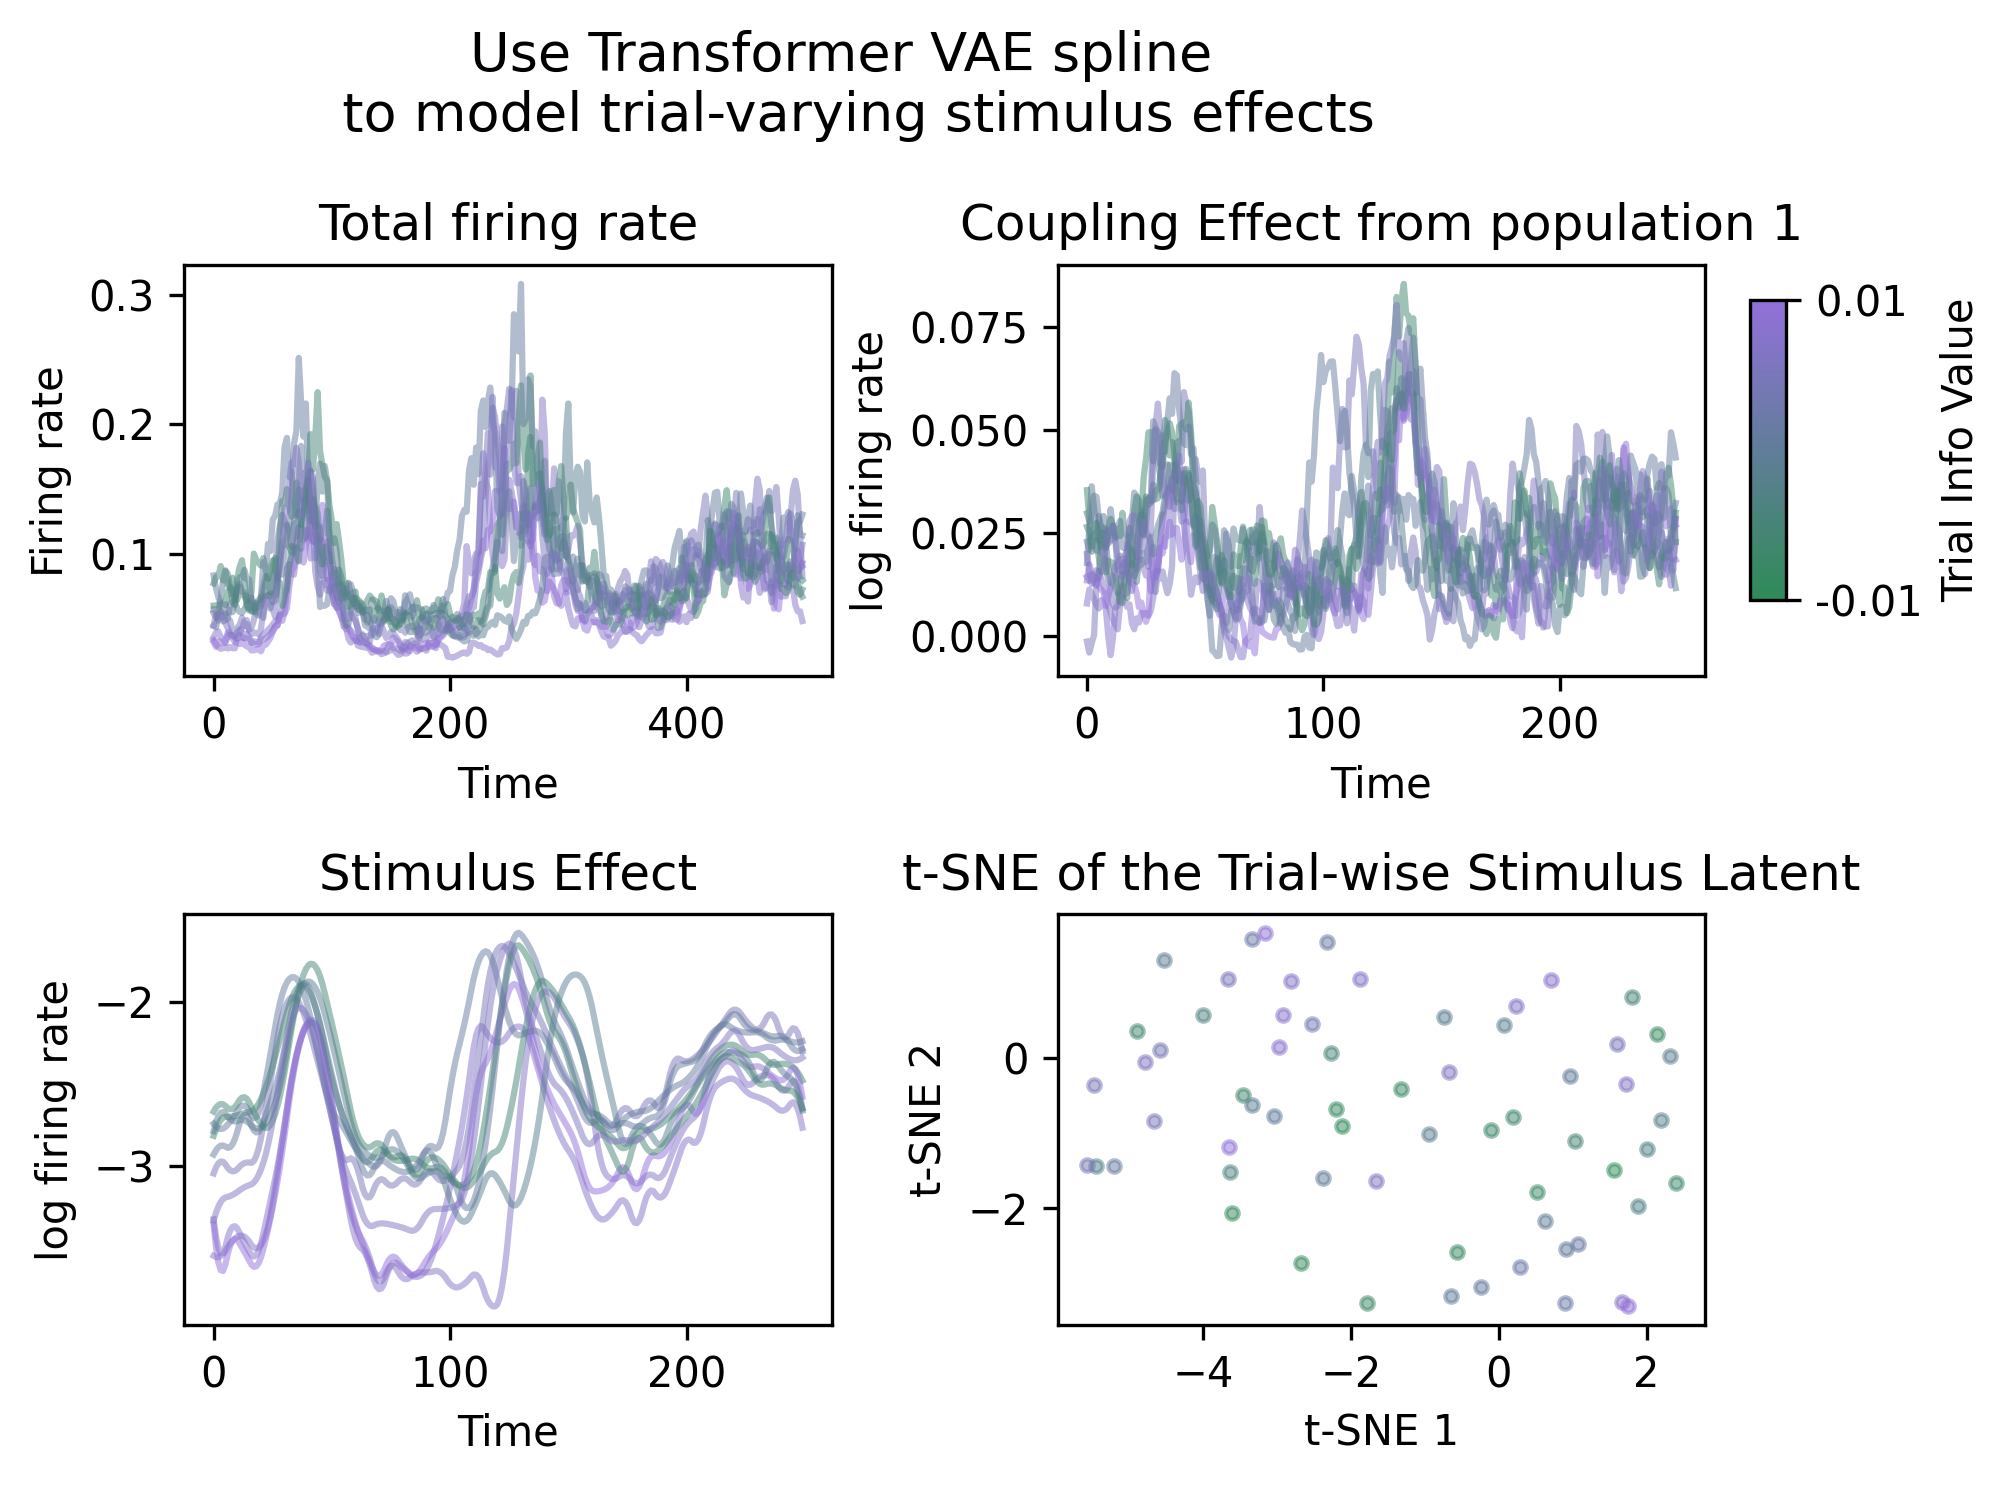

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from sklearn.manifold import TSNE

local_trial_indices = np.arange(0, 10)
neuron_idx = -1
# plot_trial_info = trial_info["bump"]
plot_trial_info = trial_info["slope"]
# plot_trial_info = trial_info["gain"]

# Define colors for min and max values
color_min = '#2E8B57'  # Sea green for minimum value
color_max = '#9370DB'  # Purple for maximum value

firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices = trainer.predict(
    dataset='test',
    batch_indices=[0],
    include_stimulus=True,
    include_coupling=True,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=True,
)

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Use Transformer VAE spline \n to model trial-varying stimulus effects', 
    fontsize=13
)



if plot_trial_info is not None:
    if isinstance(plot_trial_info, np.ndarray) and plot_trial_info.dtype == bool:
        plot_trial_info = plot_trial_info.astype(int)
    plot_trial_info_subset = plot_trial_info[trial_indices[local_trial_indices]]
    info_min, info_max = np.min(plot_trial_info), np.max(plot_trial_info)
    normalized_trial_info = (plot_trial_info[trial_indices] - info_min) / (info_max - info_min)
    cmap = LinearSegmentedColormap.from_list('custom', [color_min, color_max])
    norm = Normalize(vmin=0, vmax=1)

# Plot total firing rate
xx = np.arange(firing_rate_test.shape[0]) * 2  # Adjusted x-axis
for trial_idx in local_trial_indices:
    color = cmap(norm(normalized_trial_info[trial_idx])) if plot_trial_info is not None else color_min
    axes[0, 0].plot(
        xx, 
        np.exp(firing_rate_test[:, neuron_idx, trial_idx].cpu().numpy()), 
        color=color, 
        alpha=0.5
    )
axes[0, 0].set_title('Total firing rate')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Firing rate')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# Create colorbar with custom position [left, bottom, width, height]
cax = fig.add_axes([1.0, 0.6, 0.02, 0.2])  # Adjust these values as needed
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Trial Info Value')
cbar.set_ticks([0, 1])
cbar.set_ticklabels([f'{info_min:.2f}', f'{info_max:.2f}'])

# Plot coupling effect
for trial_idx in local_trial_indices:
    color = cmap(norm(normalized_trial_info[trial_idx])) if plot_trial_info is not None else color_min
    axes[0, 1].plot(
        trainer.model.coupling_outputs[0][1][trial_idx, neuron_idx, :].cpu().numpy(),
        color=color,
        alpha=0.5
    )
axes[0, 1].set_title('Coupling Effect from population 1')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('log firing rate')

# Plot stimulus effect
for trial_idx in local_trial_indices:
    color = cmap(norm(normalized_trial_info[trial_idx])) if plot_trial_info is not None else color_min
    axes[1, 0].plot(
        trainer.model.firing_rates_stimulus[trial_idx, neuron_idx, :].cpu().numpy(),
        color=color,
        alpha=0.5
    )
axes[1, 0].set_title('Stimulus Effect')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('log firing rate')

# Plot t-SNE in the last subplot
sti_mu_test_np = sti_mu_test.cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test

if sti_mu_test_np.shape[1] <= 2:
    for i in range(len(sti_mu_test_np)):
        color = cmap(norm(normalized_trial_info[i]))
        axes[1, 1].scatter(
            sti_mu_test_np[i, 0],
            sti_mu_test_np[i, 1],
            alpha=0.5,
            marker='.',
            c=[color]
        )
    axes[1, 1].set_title('Trial-wise Stimulus Latent')
    axes[1, 1].set_xlabel('Latent Dim 1')
    axes[1, 1].set_ylabel('Latent Dim 2')
elif np.all(sti_mu_test_np.std(axis=0) > 1e-3):
    tsne = TSNE(n_components=2, random_state=42)
    sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
    for i in range(len(sti_mu_test_tsne)):
        color = cmap(norm(normalized_trial_info[i]))
        axes[1, 1].scatter(
            sti_mu_test_tsne[i, 0],
            sti_mu_test_tsne[i, 1],
            alpha=0.5,
            marker='.',
            c=[color]
        )
    axes[1, 1].set_title('t-SNE of the Trial-wise Stimulus Latent')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
else:
    print(
        f"Stimulus latent is not varying across trials: "
        f"{sti_mu_test_np.std(axis=0).mean()}"
    )

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne.pdf', bbox_inches='tight', dpi=300)


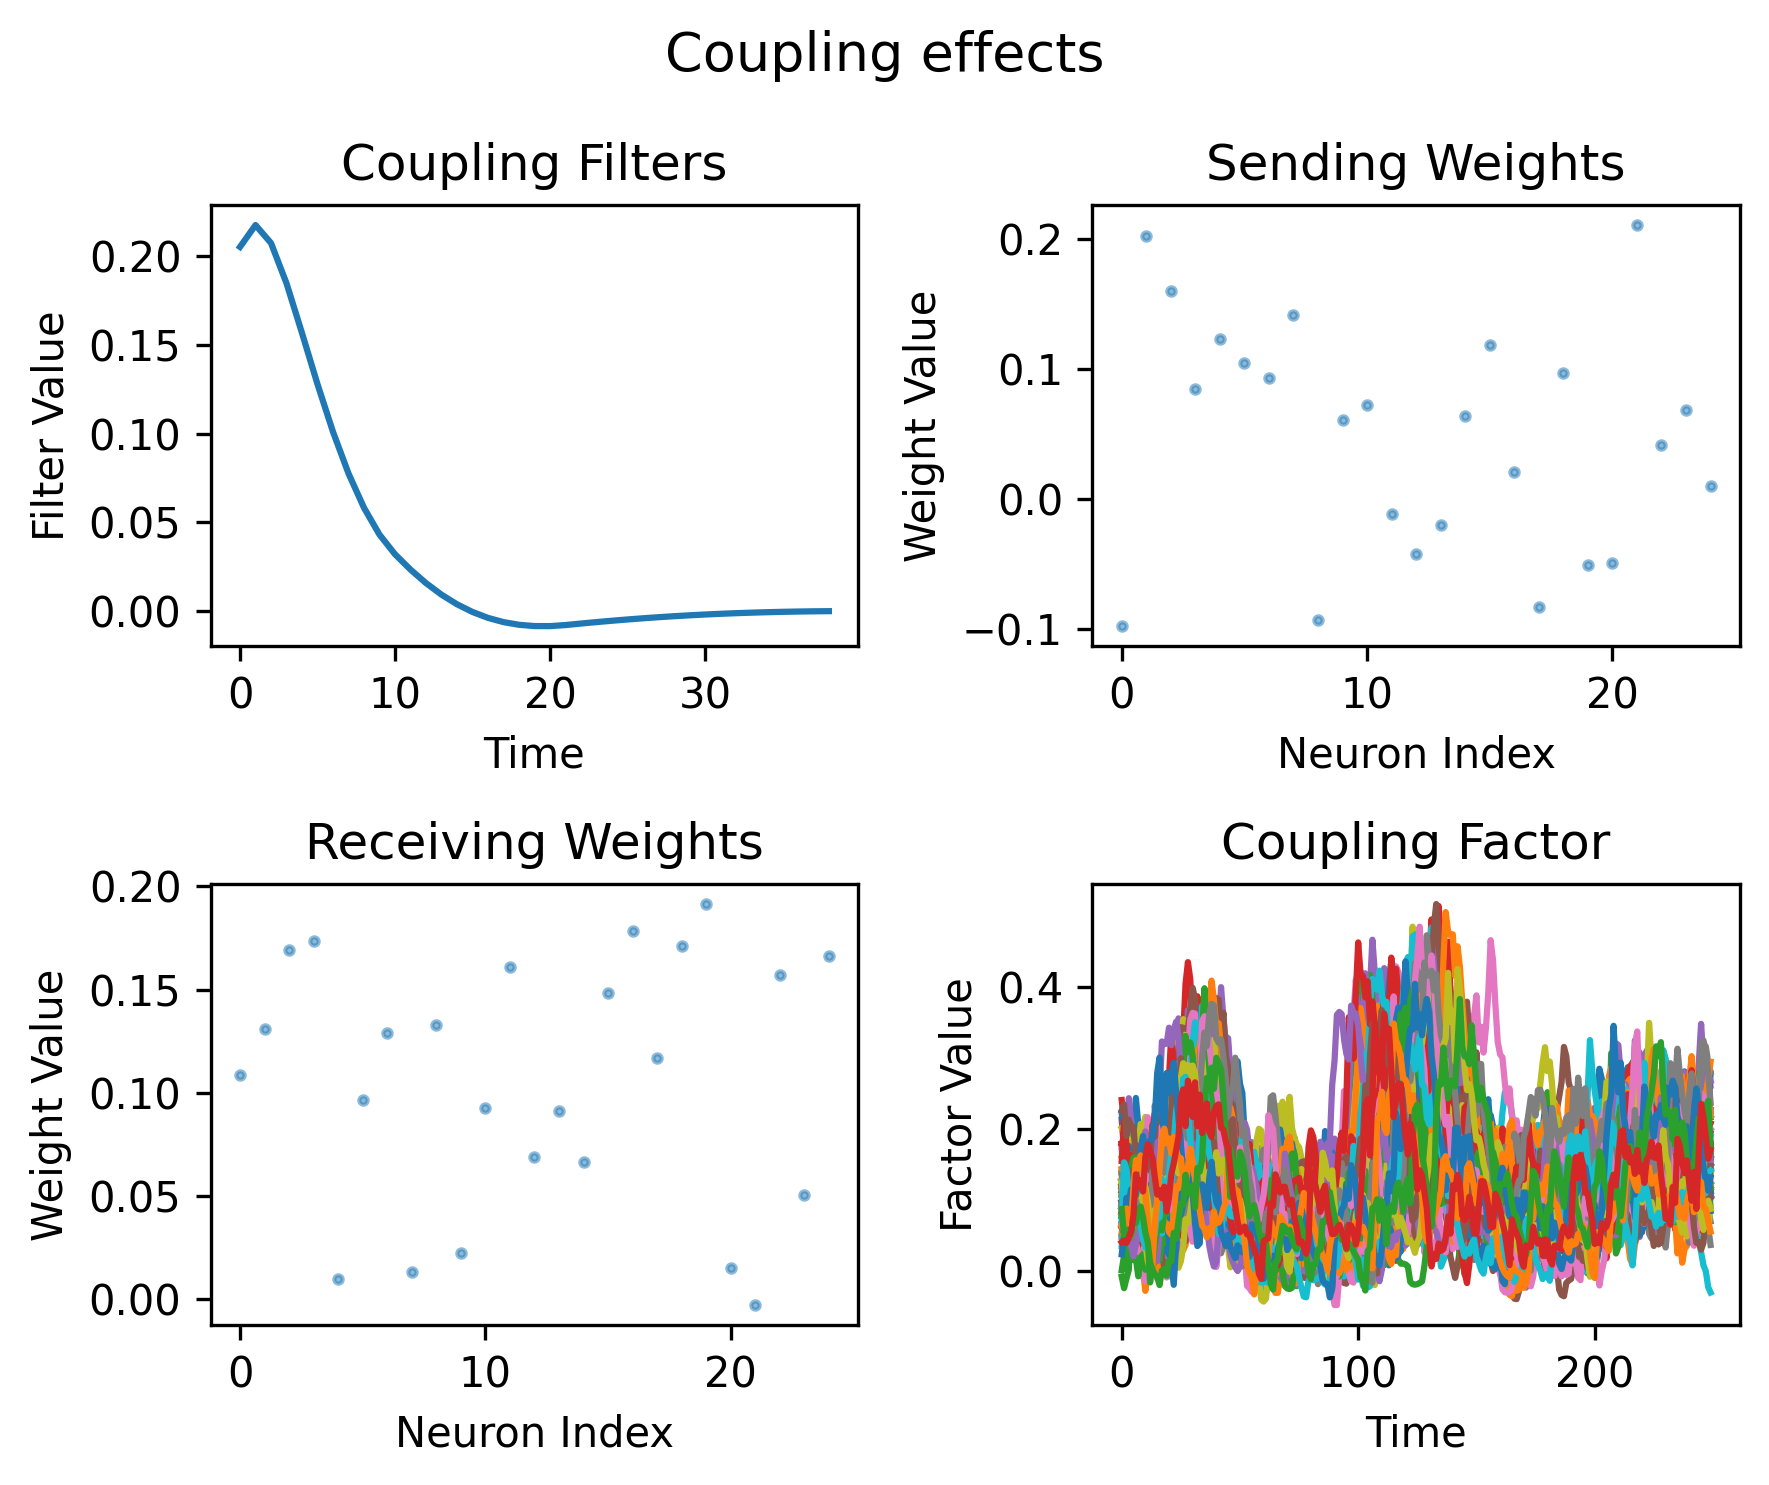

In [184]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Coupling effects', 
    fontsize=13
)

# Plot coupling filters
axes[0,0].plot(trainer.model.coupling_filters_dict["0"][0][1].cpu().numpy())
axes[0,0].set_title('Coupling Filters')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Filter Value')

# Plot sending weights 
axes[0,1].plot(trainer.model.cp_weight_sending_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[0,1].set_title('Sending Weights')
axes[0,1].set_xlabel('Neuron Index')
axes[0,1].set_ylabel('Weight Value')

# Plot receiving weights
axes[1,0].plot(trainer.model.cp_weight_receiving_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[1,0].set_title('Receiving Weights')
axes[1,0].set_xlabel('Neuron Index') 
axes[1,0].set_ylabel('Weight Value')

# Plot coupling factor
axes[1,1].plot(trainer.model.coupling_outputs_subspace[0][1].detach().cpu().numpy()[:,0,:].T)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Factor Value')

plt.tight_layout()
